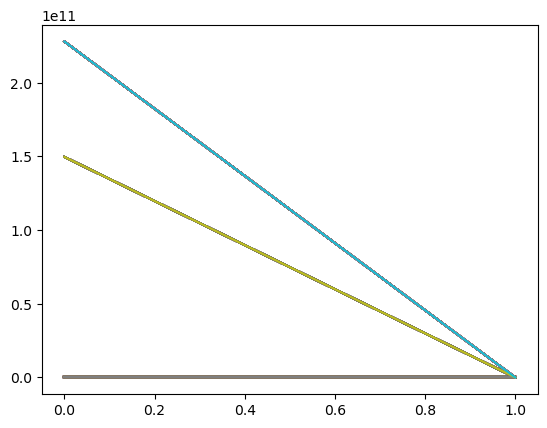

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Define bodies cleanly as dicts (position and velocity are 2D numpy arrays)
bodies = {}
bodies['Sun'] =   {'mass': 1.989e30, 'pos': np.array([0.0, 0.0]), 'vel': np.array([0.0, 0.0])}
bodies['Earth'] = {'mass': 5.972e24, 'pos': np.array([1.496e11, 0.0]), 'vel': np.array([0.0, 29.78e3])}
bodies['Mars'] =  {'mass': 6.39e23,   'pos': np.array([2.279e11, 0.0]), 'vel': np.array([0.0, 24.077e3])}

def Epos(t):
    w=np.pi*2/(365.25*24*60*60)
    R=149.6e9
    bodies['Earth']['pos']=np.array([R*np.cos(w*t),R*np.sin(w*t)])

def Mpos(t):
    w=np.pi*2/(686.98*24*60*60)
    R=227.9e9
    bodies['Mars']['pos']=np.array([R*np.cos(w*t),R*np.sin(w*t)])

def Gravity(m1, m2, pos1, pos2):
    G = 6.67430e-11
    r_vec = pos2 - pos1
    r = np.linalg.norm(r_vec)
    if r == 0.0:
        return np.zeros(2)
    # force on body1 due to body2
    F = G * m1 * m2 / r**2
    return F * (r_vec / r)

def pos_change(t):
    F1=Gravity(bodies['Sun']['mass'],bodies['Earth']['mass'],bodies['Sun']['pos'],bodies['Earth']['pos'])
    F2=Gravity(bodies['Mars']['mass'],bodies['Earth']['mass'],bodies['Mars']['pos'],bodies['Earth']['pos'])
    F3=Gravity(bodies['Sun']['mass'],bodies['Mars']['mass'],bodies['Sun']['pos'],bodies['Mars']['pos'])
    bodies['Earth']['pos']+=bodies['Earth']['vel']*t+(F1+F2)/bodies['Earth']['mass']/2*t*t
    bodies['Mars']['pos']+=bodies['Mars']['vel']*t+(F3-F2)/bodies['Mars']['mass']/2*t*t

def compute_accelerations(bodies):
    acc = {name: np.zeros(2) for name in bodies}
    G = 6.67430e-11
    names = list(bodies.keys())
    for i, ni in enumerate(names):
        for j, nj in enumerate(names):
            if i == j: 
                continue
            r_vec = bodies[nj]['pos'] - bodies[ni]['pos']
            r = np.linalg.norm(r_vec)
            if r == 0: 
                continue
            acc[ni] += G * bodies[nj]['mass'] * r_vec / r**3
    return acc

def simulate(bodies, dt, steps):
    # store trajectories
    traj = {name: np.zeros((steps+1, 2)) for name in bodies}
    for name in bodies:
        traj[name][0] = bodies[name]['pos']
    # initial accelerations
    a = compute_accelerations(bodies)
    for k in range(steps):
        # half-step velocity
        for name in bodies:
            bodies[name]['vel'] = bodies[name]['vel'] + 0.5 * a[name] * dt
        # full-step position
        for name in bodies:
            bodies[name]['pos'] = bodies[name]['pos'] + bodies[name]['vel'] * dt
        # recompute accelerations
        a_new = compute_accelerations(bodies)
        # finish velocity step
        for name in bodies:
            bodies[name]['vel'] = bodies[name]['vel'] + 0.5 * a_new[name] * dt
            traj[name][k+1] = bodies[name]['pos']
        a = a_new
    return traj

# replace the previous pos_change loop with a physical simulation
# simulate for 2 years with daily timestep
dt = 24*3600.0
total_days = 365*2
steps = int(total_days)
traj = simulate(bodies, dt, steps)

# plot trajectories
plt.figure(figsize=(8,8))
plt.plot(traj['Earth'][:,0], traj['Earth'][:,1], label='Earth')
plt.plot(traj['Mars'][:,0], traj['Mars'][:,1], label='Mars')
plt.plot(traj['Sun'][:,0], traj['Sun'][:,1], label='Sun')
plt.scatter(traj['Earth'][0,0], traj['Earth'][0,1], color='blue', s=40)
plt.scatter(traj['Mars'][0,0], traj['Mars'][0,1], color='red', s=30)
plt.scatter(traj['Sun'][0,0], traj['Sun'][0,1], color='yellow', s=80)
plt.axis('equal')
plt.legend()
plt.show()
# Spacecraft starting on Earth's surface, relative to Earth's pos/vel
sc_pos = bodies['Earth']['pos'] + np.array([6.371e6, 0.0])
sc_vel = bodies['Earth']['vel'] + np.array([0.0, 11.2e3])

bodies['Sc'] = {'mass': 0.0, 'pos': sc_pos, 'vel': sc_vel}


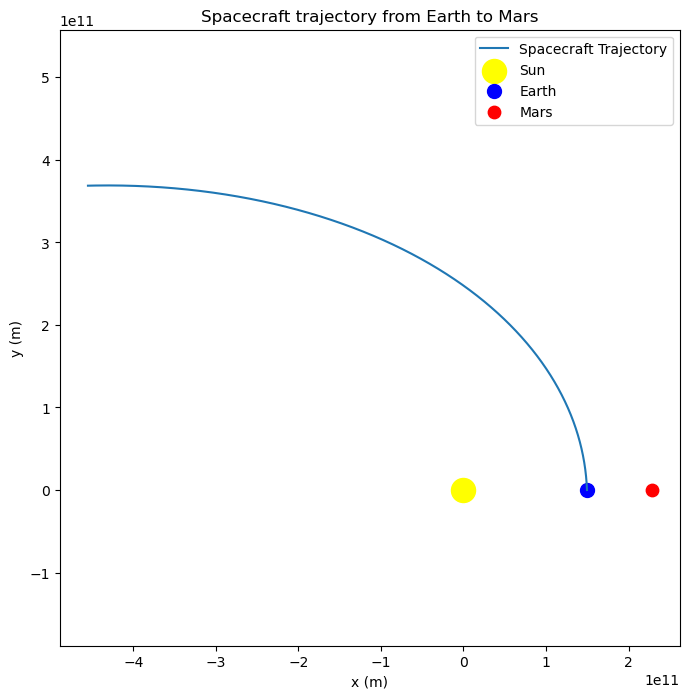

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11  # gravitational constant (m^3 kg^-1 s^-2)

# Orbital velocities (assume circular orbits, simplified)
# (Already included in the bodies dict above)

# Initial state vector: [x, y, vx, vy] for the spacecraft
sc_state0 = np.concatenate([bodies['Sc']['pos'], bodies['Sc']['vel']])

# Function to compute acceleration from all bodies (except the spacecraft itself)
def acceleration(t, sc_state):
    x, y, vx, vy = sc_state
    pos = np.array([x, y])
    a = np.zeros(2)
    for name, body in bodies.items():
        if name == 'Sc':
            continue
        r_vec = body['pos'] - pos
        r = np.linalg.norm(r_vec)
        a += G * body['mass'] * r_vec / r**3
    return [vx, vy, a[0], a[1]]

# Simulation parameters
t_span = (0, 3.154e7)  # 1 year in seconds
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# Solve ODE
sol = solve_ivp(acceleration, t_span, sc_state0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# Plot trajectory
plt.figure(figsize=(8,8))
plt.plot(sol.y[0], sol.y[1], label='Spacecraft Trajectory')
plt.scatter([bodies['Sun']['pos'][0]], [bodies['Sun']['pos'][1]], color='yellow', s=300, label='Sun')
plt.scatter([bodies['Earth']['pos'][0]], [bodies['Earth']['pos'][1]], color='blue', s=100, label='Earth')
plt.scatter([bodies['Mars']['pos'][0]], [bodies['Mars']['pos'][1]], color='red', s=80, label='Mars')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Spacecraft trajectory from Earth to Mars')
plt.legend()
plt.axis('equal')
plt.show()